# Algorithm to denoise using filters

In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf
from scipy.fft import fft2, ifft2, fftshift, ifftshift
import matplotlib.pyplot as plt

def load_image(path):
    """
    Load an RGB image from a file, converting from BGR (OpenCV default) to RGB.

    Args:
        path (str): Path to the image file.

    Returns:
        numpy.ndarray: The loaded image in RGB format.
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else None

def apply_fourier_transform(image):
    """
    Apply Fourier transform to each channel of an RGB image and shift the zero-frequency component to the center.

    Args:
        image (numpy.ndarray): Input RGB image.

    Returns:
        list of numpy.ndarray: Fourier-transformed channels.
    """
    channels = cv2.split(image)
    transformed = [fftshift(fft2(channel)) for channel in channels]
    return transformed

def apply_inverse_fourier_transform(transformed_channels):
    """
    Apply inverse Fourier transform to each channel of transformed data and shift back.

    Args:
        transformed_channels (list of numpy.ndarray): Transformed channels.

    Returns:
        list of numpy.ndarray: Channels after inverse transformation.
    """
    restored = [ifft2(ifftshift(channel)).real for channel in transformed_channels]
    return restored

def low_pass_filter(channels, cutoff):
    """
    Apply a low pass filter to the Fourier-transformed channels of an RGB image.

    Args:
        channels (list of numpy.ndarray): Fourier-transformed image channels.
        cutoff (int): Cutoff frequency for the low pass filter.

    Returns:
        list of numpy.ndarray: Filtered channels.
    """
    filtered_channels = []
    for channel in channels:
        rows, cols = channel.shape
        center = (rows // 2, cols // 2)
        mask = np.zeros((rows, cols), dtype=np.float32)
        cv2.circle(mask, center, cutoff, (1, 1, 1), thickness=-1)
        filtered_channel = channel * mask
        filtered_channels.append(filtered_channel)
    return filtered_channels

def gaussian_filter(channels, sigma):
    """
    Apply a Gaussian filter to the Fourier-transformed channels of an RGB image.

    Args:
        channels (list of numpy.ndarray): Fourier-transformed image channels.
        sigma (float): Standard deviation for the Gaussian kernel.

    Returns:
        list of numpy.ndarray: Filtered channels.
    """
    filtered_channels = []
    for channel in channels:
        rows, cols = channel.shape
        x = np.linspace(-cols//2, cols//2-1, cols)
        y = np.linspace(-rows//2, rows//2-1, rows)
        x, y = np.meshgrid(x, y)
        gaussian_kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        filtered_channel = channel * gaussian_kernel
        filtered_channels.append(filtered_channel)
    return filtered_channels

def wiener_filter(channels, k=0.01):
    """
    Apply a Wiener filter to the Fourier-transformed channels of an RGB image.

    Args:
        channels (list of numpy.ndarray): Fourier-transformed image channels.
        k (float): Constant used in the Wiener filter formula.

    Returns:
        list of numpy.ndarray: Filtered channels.
    """
    filtered_channels = []
    for channel in channels:
        local_mean = np.mean(channel)
        local_var = np.var(channel)
        noise_var = local_var / max(local_mean, 1e-9)
        wiener_kernel = local_var / (local_var + k * noise_var)
        filtered_channel = channel * wiener_kernel
        filtered_channels.append(filtered_channel)
    return filtered_channels

def calculate_metrics(real_img, denoised_img, mean_img):
    """
    Calculate and return PSNR and SSIM for image quality assessment.

    Args:
        real_img (numpy.ndarray): Original unmodified image.
        denoised_img (numpy.ndarray): Image after noise reduction.
        mean_img (numpy.ndarray): Mean image for reference.

    Returns:
        tuple: PSNR and SSIM values.
    """
    real_img_tensor = tf.convert_to_tensor(real_img, dtype=tf.float32) / 255.0
    denoised_img_tensor = tf.convert_to_tensor(denoised_img, dtype=tf.float32) / 255.0
    mean_img_tensor = tf.convert_to_tensor(mean_img, dtype=tf.float32) / 255.0

    current_psnr = tf.image.psnr(mean_img_tensor, denoised_img_tensor, max_val=1.0)
    current_ssim = tf.image.ssim(mean_img_tensor, denoised_img_tensor, max_val=1.0)

    return current_psnr.numpy(), current_ssim.numpy()

def process_images(real_paths, mean_paths, cutoff_freq=50, filter_type='low_pass', sigma=10, k=0.01):
    """
    Process a list of images through specified filters and calculate average PSNR and SSIM.

    Args:
        real_paths (list of str): Paths to the real images.
        mean_paths (list of str): Paths to the mean images.
        cutoff_freq (int): Frequency cutoff for low pass filter.
        filter_type (str): Type of filter to apply ('low_pass', 'gaussian', 'wiener').
        sigma (float): Sigma value for Gaussian filter.
        k (float): Constant for Wiener filter.

    Returns:
        tuple: Mean PSNR, mean SSIM, and list of denoised images.
    """
    psnr_values = []
    ssim_values = []
    denoised_images = []

    for real_path, mean_path in zip(real_paths, mean_paths):
        real_img = load_image(real_path)
        mean_img = load_image(mean_path)

        f_transformed_channels = apply_fourier_transform(real_img)

        if filter_type == 'low_pass':
            f_filtered_channels = low_pass_filter(f_transformed_channels, cutoff_freq)
        elif filter_type == 'gaussian':
            f_filtered_channels = gaussian_filter(f_transformed_channels, sigma)
        elif filter_type == 'wiener':
            f_filtered_channels = wiener_filter(f_transformed_channels, k)
        else:
            raise ValueError("Unknown filter type specified.")

        denoised_channels = apply_inverse_fourier_transform(f_filtered_channels)
        denoised_img = cv2.merge([np.uint8(np.clip(channel, 0, 255)) for channel in denoised_channels])

        denoised_images.append(denoised_img)

        current_psnr, current_ssim = calculate_metrics(real_img, denoised_img, mean_img)
        psnr_values.append(current_psnr)
        ssim_values.append(current_ssim)

    return np.mean(psnr_values), np.mean(ssim_values), denoised_images

def visualize_images(ground_truth_paths, noisy_paths, denoised_images, filter_type, N=5):
    # print("Visualizing images...")  # Confirm function entry
    N = min(N, len(ground_truth_paths), len(noisy_paths), len(denoised_images))
    # print(f"Number of image sets to display: {N}")  # Output the number of images to be displayed

    fig, axs = plt.subplots(N, 3, figsize=(10, N * 3))
    # print("Subplots created.")  # Confirm subplots are created

    for i in range(N):
        # print(f"Processing set {i+1}")  # Confirm each set processing
        gt_img = cv2.cvtColor(cv2.imread(ground_truth_paths[i]), cv2.COLOR_BGR2RGB)
        noisy_img = cv2.cvtColor(cv2.imread(noisy_paths[i]), cv2.COLOR_BGR2RGB)
        denoised_img = denoised_images[i]

        axs[i, 0].imshow(gt_img)
        axs[i, 0].set_title(f'Ground Truth {i+1}')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(noisy_img)
        axs[i, 1].set_title(f'Noisy {i+1}')
        axs[i, 1].axis('off')

        # Update the title to include the filter type
        axs[i, 2].imshow(denoised_img)
        axs[i, 2].set_title(f'Denoised {i+1} ({filter_type})')
        axs[i, 2].axis('off')


    plt.tight_layout()
    plt.show()
    # print("Display complete.")  # Confirm display


def pair_images(file_list):
    """
    Pair image files based on a common prefix and suffix pattern in their filenames.

    Args:
        file_list (list of str): List of filenames.

    Returns:
        dict: Dictionary containing pairs of image paths, grouped by a common prefix.
            Keys are common prefixes, values are dictionaries with keys 'real' and 'mean'
            corresponding to paths of real and mean images, respectively.
    """
    paired_images = {}
    for file in file_list:
        parts = file.split('_')
        key = '_'.join(parts[:-1])  # Extract common prefix
        image_type = parts[-1].split('.')[0]  # Extract file extension

        if key not in paired_images:
            paired_images[key] = {}
        
        # Assign paths to 'real' or 'mean' based on file extension
        paired_images[key][image_type] = os.path.join(extract_folder, file)

    return paired_images


# Parameters and file setup
extract_folder = 'CroppedImages'  # Path to dataset folder

# Assuming file_list is obtained correctly
file_list = os.listdir(extract_folder)
paired_images = pair_images(file_list)

real_paths = [paths['real'] for paths in paired_images.values()]
mean_paths = [paths['mean'] for paths in paired_images.values()]

N = 5  # To visualizes the first N image sets



# Denoising all images (100) in dataset using Low pass filter 

In [2]:
average_psnr, average_ssim, lowpass_denoised_images = process_images(real_paths, mean_paths, filter_type='low_pass')
print("Average PSNR for Low pass filter:", average_psnr)
print("Average SSIM for low pass filter:", average_ssim)

Average PSNR for Low pass filter: 32.147167
Average SSIM for low pass filter: 0.89117575


# Denoising all images (100) in dataset using Gaussian filter 

In [3]:
average_psnr, average_ssim, guassian_denoised_images = process_images(real_paths, mean_paths, filter_type='gaussian')
print("Average PSNR for Gaussian filter:", average_psnr)
print("Average SSIM for Gaussian filter:", average_ssim)

Average PSNR for Gaussian filter: 25.241447
Average SSIM for Gaussian filter: 0.81881934


# Denoising all images (100) in dataset using Weiner filter

In [4]:
average_psnr, average_ssim, weiner_denoised_images = process_images(real_paths, mean_paths, filter_type='wiener')
print("Average PSNR for Weiner filter:", average_psnr)
print("Average SSIM for Weiner filter:", average_ssim)

Average PSNR for Weiner filter: 35.492706
Average SSIM for Weiner filter: 0.9085468


# Visualize 5 sample image sets 

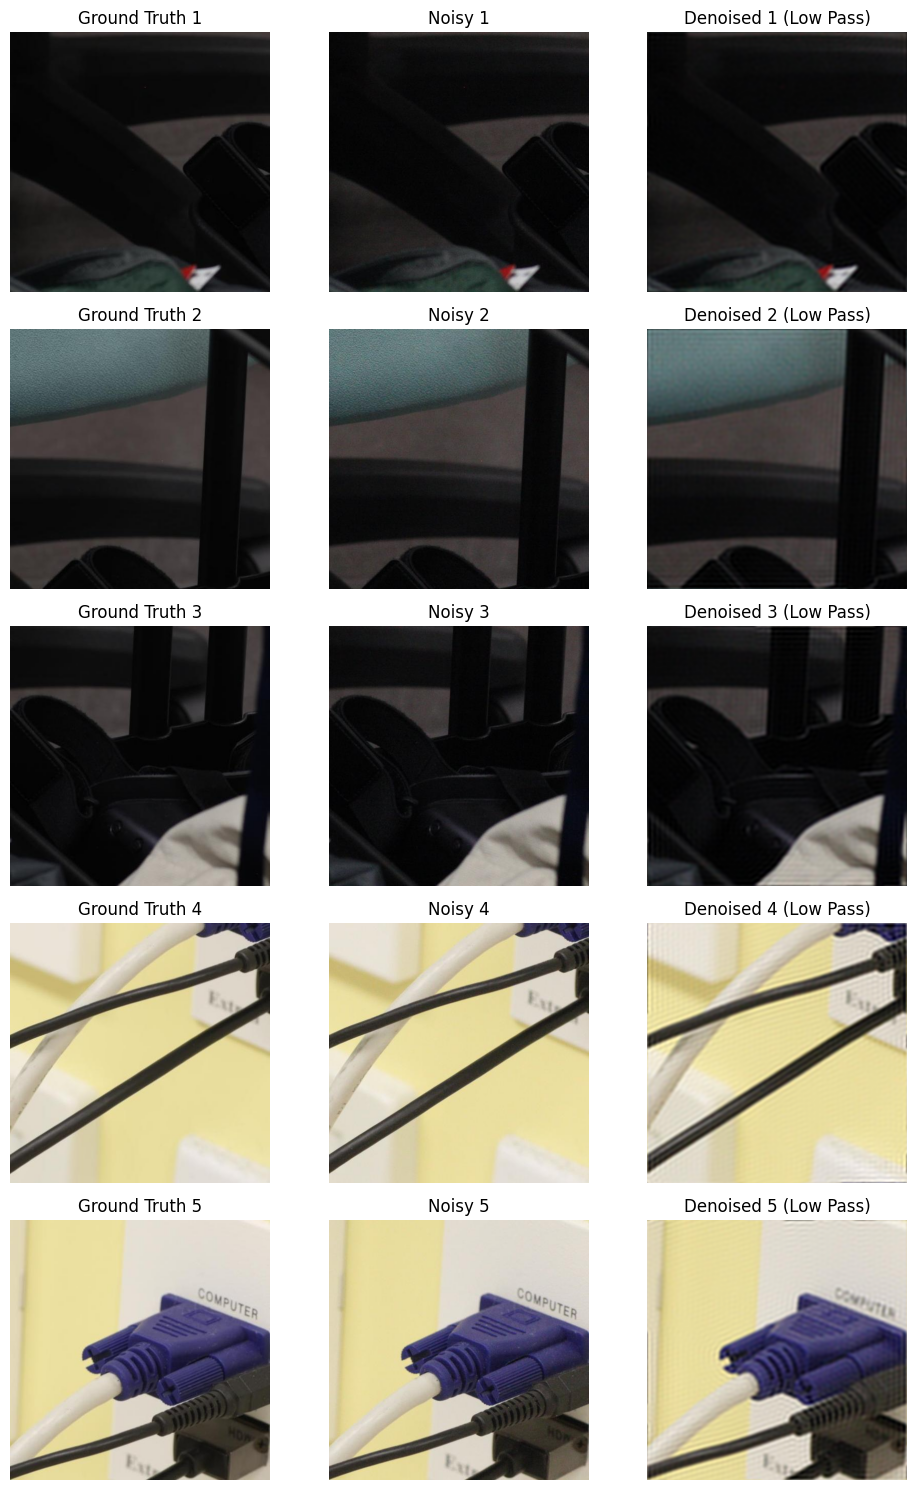

In [5]:
visualize_images(mean_paths, real_paths, lowpass_denoised_images, N=N,filter_type='Low Pass')

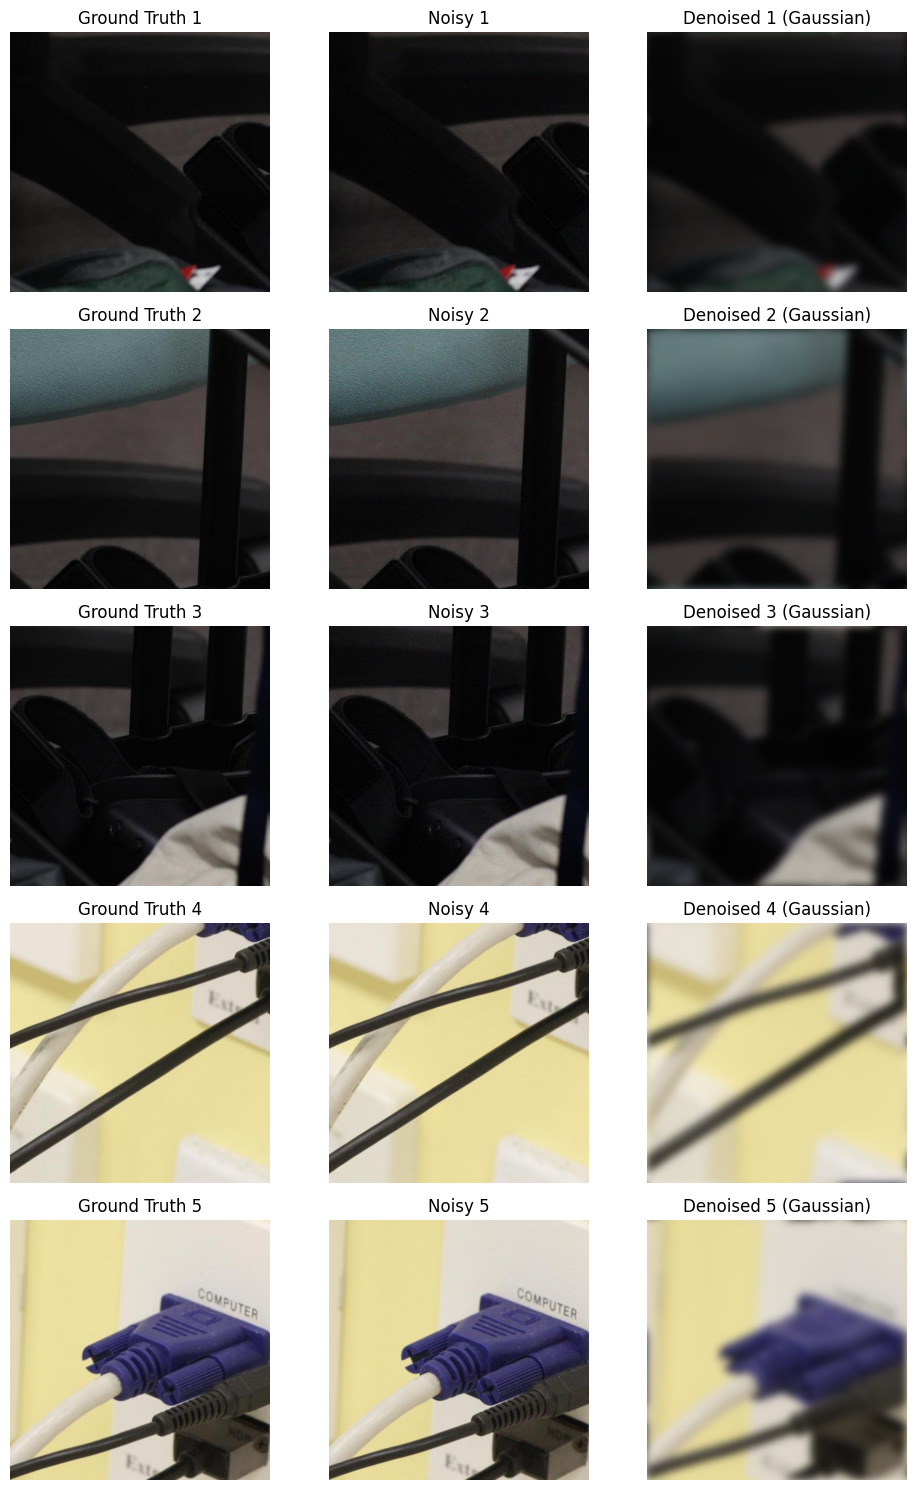

In [6]:
visualize_images(mean_paths, real_paths, guassian_denoised_images, N=N, filter_type='Gaussian')

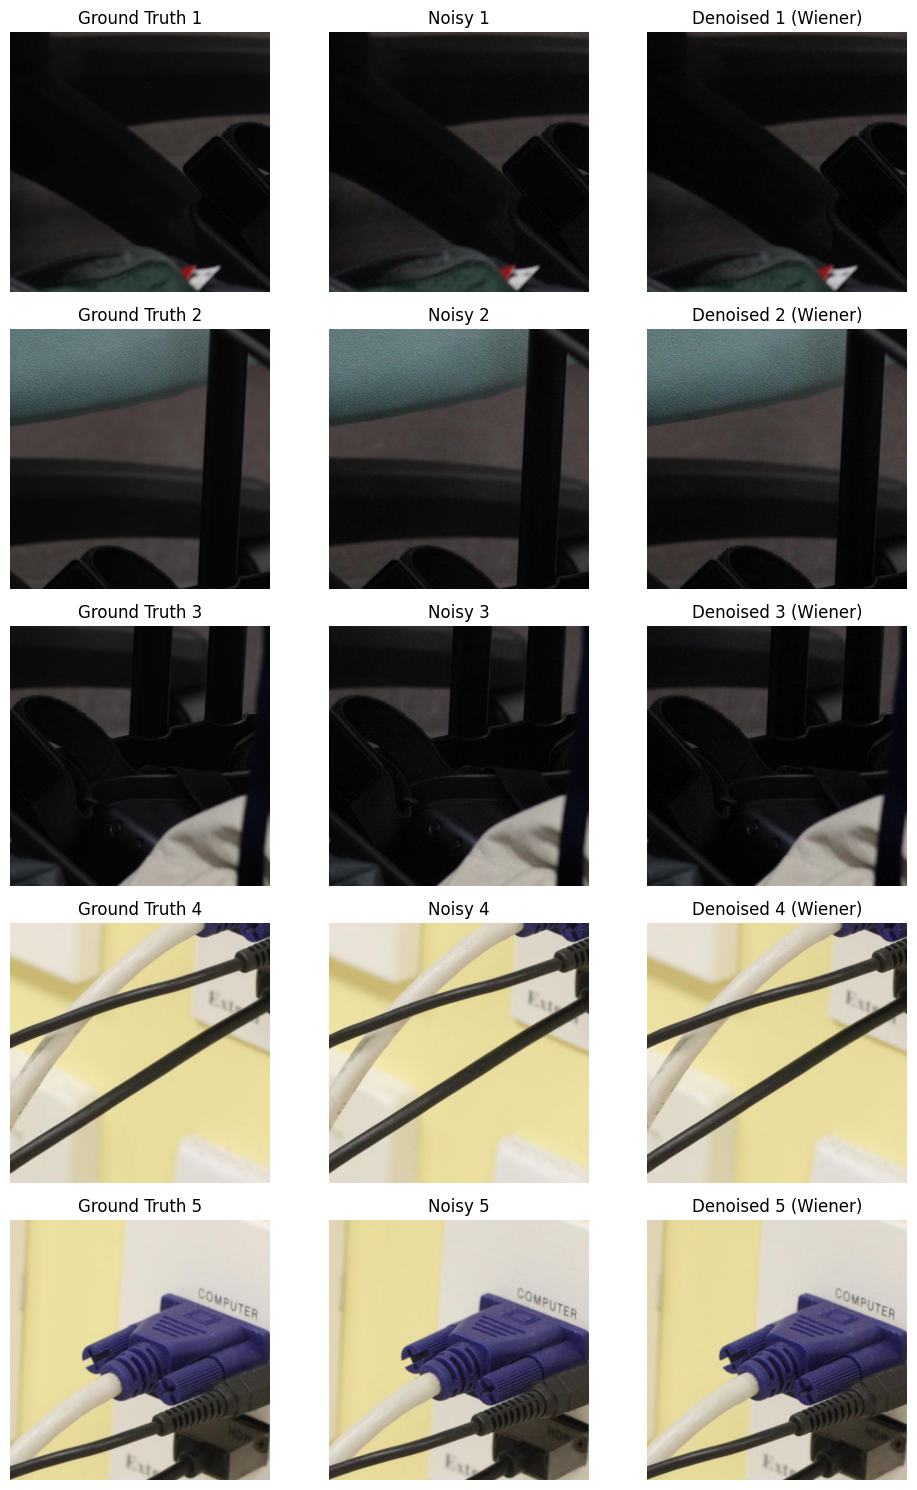

In [7]:
visualize_images(mean_paths, real_paths, weiner_denoised_images, N=N, filter_type='Wiener')

# Denoise a single Noisy image and compre with corresponding ground truth image

PSNR for single image using Low pass filter: 34.708313
SSIM for single image using Low pass filter: 0.94467944

PSNR for single image using Gaussian filter: 27.016983
SSIM for single image using Gaussian filter: 0.8859697

PSNR for single image using Wiener filter: 38.985607
SSIM for single image using Wiener filter: 0.9489948


<Figure size 1500x500 with 0 Axes>

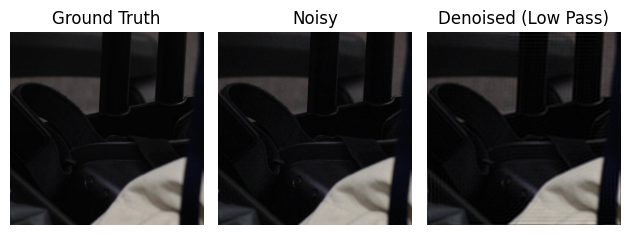

<Figure size 1500x500 with 0 Axes>

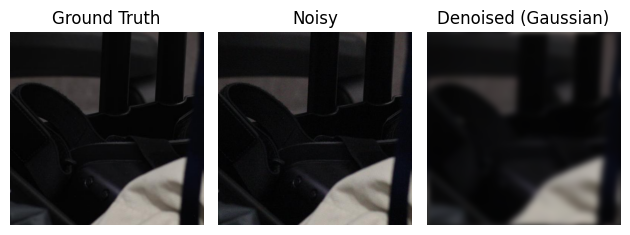

<Figure size 1500x500 with 0 Axes>

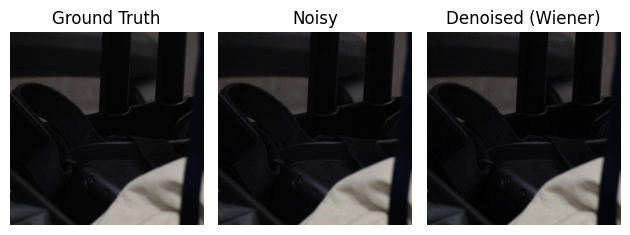

In [8]:
def process_single_image(real_path, mean_path, cutoff_freq=50, filter_type='low_pass', sigma=10, k=0.01):
    """Process an image and calculate PSNR and SSIM for it."""
    
    real_img = load_image(real_path)
    mean_img = load_image(mean_path)

    f_transformed_channels = apply_fourier_transform(real_img)

    if filter_type == 'low_pass':
        f_filtered_channels = low_pass_filter(f_transformed_channels, cutoff_freq)
    elif filter_type == 'gaussian':
        f_filtered_channels = gaussian_filter(f_transformed_channels, sigma)
    elif filter_type == 'wiener':
        f_filtered_channels = wiener_filter(f_transformed_channels, k)
    else:
        raise ValueError("Unknown filter type specified.")

    denoised_channels = apply_inverse_fourier_transform(f_filtered_channels)
    denoised_img = cv2.merge([np.uint8(np.clip(channel, 0, 255)) for channel in denoised_channels])

    current_psnr, current_ssim = calculate_metrics(real_img, denoised_img, mean_img)

    return current_psnr, current_ssim, denoised_img


def visualize_image(ground_truth_path, noisy_path, denoised_image, filter_type):
    plt.figure(figsize=(15, 5))  # Set the figure size to accommodate three images side by side

    # Load and convert images
    gt_img = cv2.cvtColor(cv2.imread(ground_truth_path), cv2.COLOR_BGR2RGB)
    noisy_img = cv2.cvtColor(cv2.imread(noisy_path), cv2.COLOR_BGR2RGB)

    # Create subplots
    fig, axs = plt.subplots(1, 3)  # Three images: ground truth, noisy, denoised

    # Display the ground truth image
    axs[0].imshow(gt_img)
    axs[0].set_title('Ground Truth')
    axs[0].axis('off')

    # Display the noisy image
    axs[1].imshow(noisy_img)
    axs[1].set_title('Noisy')
    axs[1].axis('off')

    # Display the denoised image with filter type in the title
    axs[2].imshow(denoised_image)
    axs[2].set_title(f'Denoised ({filter_type})')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


real_path = 'CroppedImages/Canon5D2_5_160_3200_chair_5_real.JPG'  # Noisy Image path, give your image own path
mean_path = 'CroppedImages/Canon5D2_5_160_3200_chair_5_mean.JPG'  # Ground Truth Image path, give your image own path

psnr_single_lowpass, ssim_single_lowpass, lowpass_denoised_img = process_single_image(real_path, mean_path, filter_type='low_pass')
print("PSNR for single image using Low pass filter:", psnr_single_lowpass)
print("SSIM for single image using Low pass filter:", ssim_single_lowpass)
print()
psnr_single_gaussian, ssim_single_gaussian, gaussian_denoised_img = process_single_image(real_path, mean_path, filter_type='gaussian')
print("PSNR for single image using Gaussian filter:", psnr_single_gaussian)
print("SSIM for single image using Gaussian filter:", ssim_single_gaussian)
print()
psnr_single_weiner, ssim_single_weiner, weiner_denoised_img = process_single_image(real_path, mean_path, filter_type='wiener')
print("PSNR for single image using Wiener filter:", psnr_single_weiner)
print("SSIM for single image using Wiener filter:", ssim_single_weiner)

visualize_image(mean_path, real_path, lowpass_denoised_img, filter_type='Low Pass')
visualize_image(mean_path, real_path, gaussian_denoised_img, filter_type='Gaussian')
visualize_image(mean_path, real_path, weiner_denoised_img, filter_type='Wiener')


